Autoencoder: Here, I build a 64x16x64 autoencoder that is trained on the sklearn digits dataset. 

In [28]:
# First we can load in the dependencies

%load_ext autoreload
%autoreload 2

from nn import nn
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, I will load in the digits dataset from sklearn. I can then inspect the dataset to see the shape and size of the datatype. 

In [29]:
digits = load_digits()
print(digits.data.shape)

(1797, 64)


We can then split the data into a training and validation test using a function from sklearn. I chose to make the test data a fifth of the size of the training dataset. The size of the training and test data is printed. 

In [30]:
X_all = digits.data
y_all = digits.target
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=0)
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (1437, 64)
X_test: (360, 64)
y_train: (1437,)
y_test: (360,)


Now, we can set up the architecture of the neural network. I chose to use MSE as the loss function because we want the output to be continuous and not binary. I chose a sigmoid activation because after testing both relu and sigmoid activations - I found that a sigmoid activation performed better. 

In [73]:
layers = [{"input_dim": 64, "output_dim": 16, "activation": "sigmoid"},
          {"input_dim": 16, "output_dim": 64, "activation": "sigmoid"}]

Here, I create a grid of different hyperparameter values. We can then loop through all of these combinations in order to find the optimal hyperparameters. I will fit a model using each set of hyperparameters and store the MSE.

In [70]:
lr_grid = [1e-1, 1e-2, 1e-3, 1e-4]
batch_grid = [10, 20, 50, 150, 200, 250, 300, 500, 750, 1000]
epochs_grid = [5, 10, 20, 30, 40, 50, 100, 200]

comb_array = np.array(np.meshgrid(lr_grid, batch_grid, epochs_grid)).T.reshape(-1, 3)

In [38]:
tune_grid = []
count = 0
for i in comb_array:
    count += 1 
    lr = i[0]
    batch_size = i[1]
    epochs = int(i[2])
    net = nn.NeuralNetwork(layers, lr = lr, seed = 42, batch_size = batch_size, epochs = epochs, loss_function = "mse")
    train_losses, val_losses = net.fit(X_train, X_train, X_test, X_test)
    # We want to save the test loss for the last epoch
    test_loss = val_losses[-1]
    tune_grid.append([lr, batch_size, epochs, test_loss])

Now, we can look through the tune grid to find the hyperparameters that result in the least test loss. 

In [39]:
grid = np.array(tune_grid)
min_key = np.argmin(grid[:,3])
print("Least MSE on validation data:", grid[:,3][min_key])
best_para=grid[min_key]
print("The optimal parameters:lr, batch_size, epochs, test loss:", best_para)

Least MSE on validation data: 50.6622203322354
The optimal parameters:lr, batch_size, epochs, test loss: [1.00000000e-03 1.00000000e+01 2.00000000e+02 5.06622203e+01]


Now we will create an instance of the neural network with the hyperparameters we found above and train the network on the training data. 

In [74]:
lr = best_para[0]
batch_size = best_para[1]
epochs = int(best_para[2])
net = nn.NeuralNetwork(layers, lr = 0.0001, seed = 42, batch_size = 10, epochs = 200, loss_function = "mse")
train_losses, val_losses = net.fit(X_train, X_train, X_test, X_test)

We will then plot the training and validation loss by epoch 

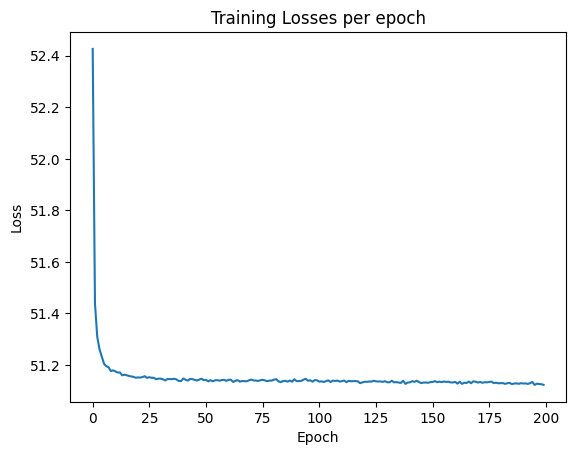

In [75]:
plt.figure()
plt.plot(train_losses)
plt.title("Training Losses per epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

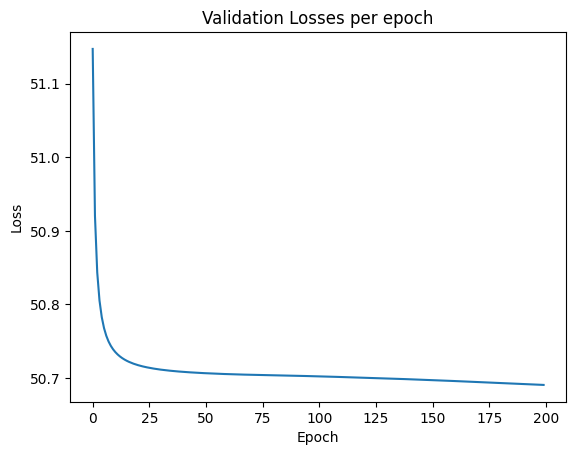

In [76]:
plt.figure()
plt.plot(val_losses)
plt.title("Validation Losses per epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

We can quantify the average reconstruction loss: 

In [77]:
preds = net.predict(X_test)
loss = mean_squared_error(preds, X_test)
print(loss)

50.690780586658434


I chose the hyperparameters for this model by searching over a grid of possible hyperparameter values. I then selected the combination that had the lowest MSE for the validation set. Basically, I just tried a bunch of parameters and just chose the ones that worked the best. 